# Notebook 2: Breast Cancer Classification using Gene Expression Data

## Environment Notes:
This notebook was created and tested on an `ml.t3.medium (2 vCPU + 4 GiB)` notebook instance running the `Python 3 (Data Science)` kernel in SageMaker Studio.

## Table of Contents
1. [Background](#1.-Background)
    1. [Experiments](#1.A.-Experiments)
    1. [Jobs](#1.B.-Jobs)
1. [Preparation](#2.-Preparation)
    1. [Import Python Libraries](#2.A.-Import-Python-Libries)
    1. [Create some necessary clients](#2.B.-Create-some-necessary-clients)
    1. [Create an experiment](#2.C.-Create-an-experiment)
    1. [Specify S3 bucket and prefix](#2.D.-Specify-S3-bucket-and-prefix)
    1. [Define local working directories](#2.E.-Define-local-working-directories)
1. [Data Preparation with Amazon SageMaker Processing](#3.-Data-Preparation-with-Amazon-SageMaker-Processing)
    1. [Upload Raw Data to S3¶](#3.A.-Upload-Raw-Data-to-S3)
    1. [Create SageMaker Processing Job Script](#3.B.-Create-SageMaker-Processing-Job-Script)
    1. [Submit SageMaker Processing Job](#3.C.-Submit-SageMaker-Processing-Job)
1. [Model Training](#4.-Model-Training)
    1. [Train Model Using a SKLearn Random Forest Algorithm](#4.A.-Train-Model-Using-a-SKLearn-Random-Forest-Algorithm)
    1. [Train Model using a Keras MLP](#4.B.-Train-Model-using-a-Keras-MLP)
    1. [Train Model Using the XGBoost Algorithm](#4.C.-Train-Model-Using-the-XGBoost-Algorithm)

---

## 1. Background
In notebook 1 of this series, we demonstrated using RNAseq data to predict HER2 status using the compute resources on the notebook server. However, using notebook server resources to process large amounts of data or train complex models is generally not a good idea. It's possible to scale up your notebook server, but any time you spend on non-compute intensive tasks (i.e. most of your time) will be wasted. A better idea is to run your notebook on a small server and submit compute-intensive tasks to independent jobs. SageMaker provides managed services for running data processing, model training, and hyperparameter tuning jobs. In this notebook, we'll demonstrate how to leverage these services to optimize the performance and cost of our tasks.

Specifically, we'll demonstrate two best practices: Experiments and Jobs

---

## 1.A. Experiments

![alt text](img/experiments.png "Experiments")

[SageMaker Experiments](https://aws.amazon.com/blogs/aws/amazon-sagemaker-experiments-organize-track-and-compare-your-machine-learning-trainings) make it as easy as possible to track data preparation and analysis steps. Organizing your ML project into experiments helps you manage large numbers of trials and alternative algorithms. Experiments also ensure that any artifacts your generate for production use can be traced back to their source.

## 1.B. Jobs

![alt text](img/jobs.png "Jobs")

[SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html) processing, training, and tuning jobs allow data scientists to submit compute-heavy processes to external services. This keeps costs optimized and ensures that these tasks run in reproducible environments. It also improves data scientist productivity by allowing these jobs to run in "the background" and provides resiliancy if something happens to your notebook environment.

## 2. Preparation

Let's start by specifying:

- The Python libraries that we'll use throughout the analysis
- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

### 2.A. Import Python Libraries

In [12]:
import os
import json
import boto3
import argparse
import numpy as np
import pandas as pd
import xgboost as xgb
from time import strftime
from botocore.client import ClientError

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score

import sagemaker
from sagemaker import get_execution_role, session
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.analytics import ExperimentAnalytics, TrainingJobAnalytics
from sagemaker.tensorflow import TensorFlow
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

import pickle
import matplotlib.pyplot as plt 
import seaborn as sns

### 2.B. Create some necessary clients

In [13]:
session = boto3.session.Session()
sm_session = sagemaker.session.Session()
region = session.region_name
role = get_execution_role()
s3 = boto3.client('s3', region_name=region)
account_id = boto3.client('sts').get_caller_identity().get('Account')

### 2.C. Create an experiment

In [14]:
create_date = strftime("%Y-%m-%d-%H-%M-%S")
brca_her2_experiment = Experiment.create(experiment_name = f"BRCA-HER2-{create_date}",
                                    description = "Predict HER2 status using TCGA RNAseq data.",
                                    tags = [{'Key': 'Creator', 'Value': 'bloyal'}])

### 2.D. Specify S3 bucket and prefix

In [ ]:
# Create S3 Buckets for this project
bucket_name = f"brca-her2-classifier-{account_id}"
print(f"S3 bucket name is {bucket_name}")

### 2.E. Define local working directories

In [16]:
WORKING_DIR = os.getcwd()
DATA_DIR = os.path.join(WORKING_DIR, "data")
print(f"Working directory is {WORKING_DIR}")
print(f"Data directory is {DATA_DIR}")

Working directory is /root/RNAseq_Tertiary_Analysis
Data directory is /root/RNAseq_Tertiary_Analysis/data


## 3. Data Preparation  with Amazon SageMaker Processing

Amazon SageMaker Processing allows you to run steps for data pre- or post-processing, feature engineering, data validation, or model evaluation workloads on Amazon SageMaker. Processing jobs accept data from Amazon S3 as input and store data into Amazon S3 as output.

![processing](https://sagemaker.readthedocs.io/en/stable/_images/amazon_sagemaker_processing_image1.png)

Here, we'll import the dataset and transform it with SageMaker Processing, which can be used to process terabytes of data in a SageMaker-managed cluster separate from the instance running your notebook server. In a typical SageMaker workflow, notebooks are only used for prototyping and can be run on relatively inexpensive and less powerful instances, while processing, training and model hosting tasks are run on separate, more powerful SageMaker-managed instances.  SageMaker Processing includes off-the-shelf support for Scikit-learn, as well as a Bring Your Own Container option, so it can be used with many different data transformation technologies and tasks.    

To use SageMaker Processing, simply supply a Python data preprocessing script as shown below.  For this example, we're using a SageMaker prebuilt Scikit-learn container, which includes many common functions for processing data.  There are few limitations on what kinds of code and operations you can run, and only a minimal contract:  input and output data must be placed in specified directories.  If this is done, SageMaker Processing automatically loads the input data from S3 and uploads transformed data back to S3 when the job is complete.

### 3.A. Upload Raw Data to S3

Download the raw data

In [17]:
# Define working directories
WORKING_DIR = os.getcwd()
DATA_DIR = os.path.join(WORKING_DIR, "data")
print(f"Working directory is {WORKING_DIR}")
print(f"Data directory is {DATA_DIR}")

# Get TCGA BRCA Gene Expression Data
!wget https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/HiSeqV2_PANCAN.gz -nc -P $DATA_DIR/input/raw/
!gzip -df $DATA_DIR/input/raw/HiSeqV2_PANCAN.gz

# Get TCGA BRCA Phenotype Data
!wget https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/BRCA_clinicalMatrix -nc -P $DATA_DIR/input/raw/

Working directory is /root/RNAseq_Tertiary_Analysis
Data directory is /root/RNAseq_Tertiary_Analysis/data
--2022-01-18 15:38:34--  https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/HiSeqV2_PANCAN.gz
Resolving tcga.xenahubs.net (tcga.xenahubs.net)... 3.85.156.153, 35.168.172.110, 52.2.123.35, ...
Connecting to tcga.xenahubs.net (tcga.xenahubs.net)|3.85.156.153|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://tcga-xena-hub.s3.us-east-1.amazonaws.com:443/download/TCGA.BRCA.sampleMap/HiSeqV2_PANCAN.gz [following]
--2022-01-18 15:38:34--  https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap/HiSeqV2_PANCAN.gz
Resolving tcga-xena-hub.s3.us-east-1.amazonaws.com (tcga-xena-hub.s3.us-east-1.amazonaws.com)... 52.216.30.0
Connecting to tcga-xena-hub.s3.us-east-1.amazonaws.com (tcga-xena-hub.s3.us-east-1.amazonaws.com)|52.216.30.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83389754 (80M) [

In [18]:
region

'us-east-1'

In [19]:
# Check if bucket already exists. If it does not, create it
try:
    s3.head_bucket(Bucket=bucket_name)
except ClientError:
    s3.create_bucket(Bucket=bucket_name)
    print(f"Created Bucket: {bucket_name} in Region: {region}")

In [ ]:
clinical_source = sm_session.upload_data(f"{DATA_DIR}/input/raw/BRCA_clinicalMatrix", bucket=bucket_name, key_prefix='data/input')
RNAseq_source = sm_session.upload_data(f"{DATA_DIR}/input/raw/HiSeqV2_PANCAN", bucket=bucket_name, key_prefix='data/input')
print(f"Clinical phenotypes now available at {clinical_source}")
print(f"Normalized expression data now available at {RNAseq_source}")

### 3.B. Create SageMaker Processing Job Script

In [21]:
#Create folder for processing script
os.makedirs(os.path.join(WORKING_DIR,"scripts/processing"), exist_ok=True)

In [22]:
%%writefile scripts/processing/processing.py

import os
import argparse
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def _parse_args():

    parser = argparse.ArgumentParser()
    
    parser.add_argument('--train_test_split_ratio', type=float, default=0.2)
    parser.add_argument('--local_path', type=str, default="/opt/ml/processing")

    return parser.parse_known_args()

if __name__ == "__main__":
        
    ### Command line parser
    args, _ = _parse_args()

    DATA_DIR = os.path.join(args.local_path, "input")
    print(f"Data directory is {DATA_DIR}")
    
    ### Load Gene Expression RNA-seq
    genom = pd.read_csv(os.path.join(DATA_DIR, "HiSeqV2_PANCAN"), sep='\t')
    genom_identifiers = genom["sample"].values.tolist()

    ### Load Phenotypes
    phenotypes = pd.read_csv(os.path.join(DATA_DIR, "BRCA_clinicalMatrix"),sep='\t')

    #### Keep `HER2_Final_Status_nature2012` target variables
    phenotypes_subset = phenotypes[["sampleID", "HER2_Final_Status_nature2012"]].reset_index(drop=True)
    phenotypes_subset.fillna("Negative", inplace=True)

    ### Transpose Methylation and Gene Expression datasets in order to join with Phenotypes on sampleID
    genom_transpose = genom.set_index("sample").transpose().reset_index().rename(columns={"index": "sampleID"})

    ### Merge datasets
    df = pd.merge(phenotypes_subset, genom_transpose, on="sampleID", how="left")

    ### Encode target
    df["target"] = [0 if t == "Negative" else 1 for t in df['HER2_Final_Status_nature2012']]
    df = df.drop(['HER2_Final_Status_nature2012','sampleID'], axis=1)
    ## Move target to first column
    df.insert(loc=0, column='target', value=df.pop('target'))
    ## Drop rows with NaN values
    df = df.dropna()

    ### Train-Valid-Test split
    # Hold out 20% of the data for testing
    train_df, test_df = train_test_split(df, test_size=args.train_test_split_ratio)
    # Hold out an additional 20% of the training data for validaton
    train_df, val_df = train_test_split(train_df, test_size=args.train_test_split_ratio)

    print(f"The training data has {train_df.shape[0]} records and {train_df.shape[1]} columns.")
    print(f"The validation data has {val_df.shape[0]} records and {val_df.shape[1]} columns.")
    print(f"The test data has {test_df.shape[0]} records and {test_df.shape[1]} columns.")
   
    # Save data

    os.makedirs(os.path.join(args.local_path, "output/train"), exist_ok=True)
    training_output_path = os.path.join(args.local_path,'output/train/train.csv')
    train_df.to_csv(training_output_path, header=True, index=False)
    print(f"Training data saved to {training_output_path}")
    
    os.makedirs(os.path.join(args.local_path, "output/val"), exist_ok=True)
    val_output_path = os.path.join(args.local_path,'output/val/val.csv')
    val_df.to_csv(val_output_path, header=True, index=False)
    print(f"Validation data saved to {val_output_path}")
          
    os.makedirs(os.path.join(args.local_path, "output/test"), exist_ok=True)
    test_output_path = os.path.join(args.local_path,'output/test/test.csv')
    test_df.to_csv(test_output_path, header=True, index=False)
    print(f"Test data saved to {test_output_path}")        

Overwriting scripts/processing/processing.py


In [23]:
### Uncomment to test processing script locally
# !python scripts/processing/processing.py --local_path data

### 3.C. Submit SageMaker Processing Job

In [ ]:
# Define the inputs for the processing job
inputs = [ProcessingInput(source=f"s3://{bucket_name}/data/input/",
                          destination='/opt/ml/processing/input',
                          s3_data_distribution_type='ShardedByS3Key'
                         )         
         ]

# Define the outputs for the processing job
outputs = [ProcessingOutput(output_name='train',
                            source='/opt/ml/processing/output/train',
                            destination=f"s3://{bucket_name}/data/output/train/"
                           ),
           ProcessingOutput(output_name='validation',
                            source='/opt/ml/processing/output/val',
                            destination=f"s3://{bucket_name}/data/output/val/"
                           ),
           ProcessingOutput(output_name='test',
                            source='/opt/ml/processing/output/test',
                            destination=f"s3://{bucket_name}/data/output/test/"
                           )
          ]

sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.m5.xlarge',
                                     instance_count=1)

processing_run_name = f"Processing-{strftime('%Y-%m-%d-%H-%M-%S')}"

sklearn_processor.run(
    job_name=processing_run_name,
    code='scripts/processing/processing.py',
    inputs=inputs,
    outputs=outputs, 
    experiment_config={
        "ExperimentName": brca_her2_experiment.experiment_name,
        "TrialComponentDisplayName": processing_run_name
        },
    wait=True
)

Download Processed Data from S3

In [25]:
sm_session.download_data(f"{DATA_DIR}/output/train", bucket=bucket_name, key_prefix='data/output/train/train.csv')
sm_session.download_data(f"{DATA_DIR}/output/val", bucket=bucket_name, key_prefix='data/output/val/val.csv')
sm_session.download_data(f"{DATA_DIR}/output/test", bucket=bucket_name, key_prefix='data/output/test/test.csv')

## 4. Model Training

Now that our training data is set up, we can train some models. To highlight the benefits of experiment tracking, we're going to train models using three different frameworks:
- The XGBoost algorithm
- The random forest model from Scikit Learm
- A multi-layer perceptron (MLP) neural network in Keras

In [26]:
# define the data type and paths to the training and validation datasets
content_type = "text/csv"

s3_input_train = sagemaker.inputs.TrainingInput(
    f"s3://{bucket_name}/data/output/train/train.csv", 
    content_type=content_type
)

s3_input_validation = sagemaker.inputs.TrainingInput(
    f"s3://{bucket_name}/data/output/val/val.csv", 
    content_type=content_type
)

s3_input_test = sagemaker.inputs.TrainingInput(
    f"s3://{bucket_name}/data/output/test/test.csv", 
    content_type=content_type
)

model_output_path = f"s3://{bucket_name}/"

### 4.A. Train Model Using a SKLearn Random Forest Algorithm

Create training script

In [27]:
#Create a trial
rf_trial = Trial.create(
        trial_name=f"RF-Trial-{strftime('%Y-%m-%d-%H-%M-%S')}",
        experiment_name=brca_her2_experiment.experiment_name
    )

In [28]:
#Create folder for RF training script
os.makedirs(os.path.join(WORKING_DIR,"scripts/rf_train"), exist_ok=True)

In [29]:
%%writefile scripts/rf_train/rf_train.py

import argparse
import joblib
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score
from smexperiments.tracker import Tracker

def model_fn(model_dir):
    """Load model for inference"""
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

def _parse_args():
    """Parse job parameters."""
    
    parser = argparse.ArgumentParser()
    
    # Hyperparameters are described here.
    parser.add_argument("--n-estimators", type=int, default=10)
    parser.add_argument("--min-samples-leaf", type=int, default=3)
    
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--validation", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    
    parser.add_argument("--train-file", type=str, default="train.csv")
    parser.add_argument("--validation-file", type=str, default="val.csv")
    parser.add_argument("--test-file", type=str, default="test.csv")
    
    parser.add_argument("--target", type=str, default="target")

    return parser.parse_known_args()


if __name__ == "__main__":

    try:
        my_tracker = Tracker.load()
    except ValueError:
        my_tracker = Tracker.create()
    
    print("extracting arguments")
    args, _ = _parse_args()
    print(args)

    print("Preparing data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    validation_df = pd.read_csv(os.path.join(args.validation, args.validation_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))
    
    train_labels = np.array(train_df.pop("target"))
    validation_labels = np.array(validation_df.pop("target"))
    test_labels = np.array(test_df.pop("target"))
    
    train_np = np.array(train_df)
    validation_np = np.array(validation_df)    
    test_np = np.array(test_df)
        
    # Use the scale_pos_weight parameter to account for the imbalanced classes in our data
    pos_weight = float(np.sum(train_labels == 0) / np.sum(train_labels == 1))

    # train
    print("training model")
    classifier = RandomForestClassifier(
        n_estimators=args.n_estimators, 
        min_samples_leaf=args.min_samples_leaf, 
        class_weight="balanced",
        n_jobs=-1, 
        verbose=1
    )

    classifier.fit(train_np, train_labels)
    
    print("Evaluating model")

    # evaluate test data
    test_predictions = classifier.predict(test_np)
    
    accuracy = accuracy_score(test_labels, test_predictions)
    my_tracker.log_metric(metric_name='test:accuracy', value=accuracy)  
    
    precision = precision_score(test_labels, test_predictions)
    my_tracker.log_metric(metric_name='test:precision', value=precision) 
    
    f1 = f1_score(test_labels, test_predictions)
    my_tracker.log_metric(metric_name='test:f1', value=f1)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")
        
    my_tracker.close()    
    
    print("Saving model")
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(classifier, path)
    print("Model saved to " + path)

Overwriting scripts/rf_train/rf_train.py


Create a `requirements.txt` file in the training script directory to install additional dependencies in the training container. This is a great way to install an extra package or two without creating your own container image from scratch!

In [30]:
!echo "sagemaker-experiments" > scripts/rf_train/requirements.txt

In [31]:
# ### Uncomment to test processing script locally
# !python scripts/rf_train/rf_train.py --n-estimators 100 \
#                    --min-samples-leaf 2 \
#                    --model-dir models \
#                    --train "data/output/train" \
#                    --validation "data/output/val" \
#                    --test "data/output/test" \
#                    --target "target"

In [32]:
rf_job_name= f"RF-Training-Job-{strftime('%Y-%m-%d-%H-%M-%S')}"

rf_estimator = SKLearn(
    entry_point="rf_train.py",
    source_dir = "scripts/rf_train",   
    output_path = model_output_path,
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    framework_version="0.23-1",
    enable_sagemaker_metrics=True,
    base_job_name=rf_job_name,
    hyperparameters={
        "n-estimators": 100,
        "min-samples-leaf": 3,
        "target": "target",
    },
)

rf_estimator.fit(
    {'train': s3_input_train, 'validation': s3_input_validation, 'test': s3_input_test},
    job_name=rf_job_name,
    experiment_config={
            "TrialName": rf_trial.trial_name,
            "TrialComponentDisplayName": rf_job_name,
        },
    wait=False
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: RF-Training-Job-2022-01-18-15-45-12


---

In [33]:
# # Download model
# print(rf_job_name)
# print(bucket_name)
# sm_session.download_data("models", bucket=bucket_name, key_prefix=f"{rf_job_name}/output/model.tar.gz")
# !tar xvfz models/model.tar.gz
# from joblib import dump, load
# rf_model = load('model.joblib') 
# rf_model.get_params()

### 4.B. Train Model using a Keras MLP

In [34]:
#Create a trial
tf_trial = Trial.create(
        trial_name=f"TF-Trial-{strftime('%Y-%m-%d-%H-%M-%S')}",
        experiment_name=brca_her2_experiment.experiment_name
    )

In [35]:
#Create folder for Keras training script
os.makedirs(os.path.join(WORKING_DIR,"scripts/tf_train"), exist_ok=True)

In [36]:
%%writefile scripts/tf_train/tf_train.py
import argparse
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score
from smexperiments.tracker import Tracker

import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical 
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, \
 Conv1D, MaxPool1D, Flatten, concatenate

def binary_mlp(metrics, output_bias=None):
    ### Setup loss and output node activation

    output_activation = "sigmoid"
    loss = tf.keras.losses.BinaryCrossentropy()#from_logits=True

    
    ### Gene Expression Encoder
    genom_input = Input(shape = (20530,),
                        name = 'genom_input'
                       )
    genom_layer = Dense(units = 64,
                        kernel_regularizer = tf.keras.regularizers.l2(0.001),
                        activation = 'relu',
                        name = 'genom_layer1'
                       )(genom_input)
    #genom_layer = BatchNormalization(name = 'genom_layer1_normalized')(genom_layer)
    genom_layer = Dense(units = 32,
                        kernel_regularizer = tf.keras.regularizers.l2(0.001),
                        activation = 'relu',
                        name = 'genom_layer2'
                       )(genom_layer)    
    

    X = BatchNormalization(name = 'X_normalized')(genom_layer)


    X = Dense(units = 32,
              activation = 'relu',
              kernel_regularizer = tf.keras.regularizers.l2(0.001),
              name = 'X1'
             )(X)
    X = Dense(units = 16,
              activation = 'relu',
              kernel_regularizer = tf.keras.regularizers.l2(0.001),
              name = 'X2'
             )(X)

    output = Dense(units = 1, activation = output_activation)(X)
    
    ### Compile the model
    model = tf.keras.Model(genom_input, output)

    model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics
                 )
    
    return model

def _parse_args():
    """Parse job parameters."""
    
    parser = argparse.ArgumentParser()
    
    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch_size', type=int, default=100)
    parser.add_argument('--learning_rate', type=float, default=0.1)

    # input data and model directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--validation", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    
    parser.add_argument("--train-file", type=str, default="train.csv")
    parser.add_argument("--validation-file", type=str, default="val.csv")
    parser.add_argument("--test-file", type=str, default="test.csv")
    
    parser.add_argument("--target", type=str, default="target")

    args, _ = parser.parse_known_args()

    return parser.parse_known_args()


if __name__ =='__main__':

    try:
        my_tracker = Tracker.load()
    except ValueError:
        my_tracker = Tracker.create()
    
    print("extracting arguments")
    args, _ = _parse_args()
    print(args)

    print("Preparing data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    validation_df = pd.read_csv(os.path.join(args.validation, args.validation_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))
    
    train_labels = np.array(train_df.pop("target"))
    validation_labels = np.array(validation_df.pop("target"))
    test_labels = np.array(test_df.pop("target"))
    
    train_np = np.array(train_df)
    validation_np = np.array(validation_df)    
    test_np = np.array(test_df)
    
    EPOCHS = 150
    BATCH_SIZE = 32

    EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        verbose=1,
        patience=10,
        mode='auto',
        restore_best_weights=True
    )

    # Instantiate classifier
    classifier = binary_mlp(metrics=["accuracy", "binary_accuracy"], output_bias=None)    
    
    # Fit classifier
    history = classifier.fit(x=train_np,
                                y=train_labels,
                                validation_data=(validation_np,validation_labels),
                                callbacks=[EARLY_STOPPING],               
                                batch_size=BATCH_SIZE,
                                epochs=EPOCHS,
                                verbose=1
    )
    
    print("Evaluating model")
    for epoch, value in enumerate(history.history["loss"]):
        my_tracker.log_metric(metric_name='train:loss', value=value, iteration_number=epoch)
        
    for epoch, value in enumerate(history.history["val_loss"]):
        my_tracker.log_metric(metric_name='validation:loss', value=value, iteration_number=epoch)        

    # evaluate test data
    test_predictions = classifier(test_np)    
    discrete_predictions = np.around(test_predictions).astype(int)
    
    accuracy = accuracy_score(test_labels, discrete_predictions)
    my_tracker.log_metric(metric_name='test:accuracy', value=accuracy) 
    
    precision = precision_score(test_labels, discrete_predictions)
    my_tracker.log_metric(metric_name='test:precision', value=precision)   
    
    f1 = f1_score(test_labels, discrete_predictions)
    my_tracker.log_metric(metric_name='test:f1', value=f1)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")
        
    my_tracker.close()
    
    print("Saving model")
    classifier.save(args.model_dir)
    print(f"Model saved to {args.model_dir}")

Overwriting scripts/tf_train/tf_train.py


In [37]:
!echo "sagemaker-experiments" > scripts/tf_train/requirements.txt

In [38]:
# # Test locally
# !python scripts/tf_train/tf_train.py --epochs 10 \
#                    --batch-size 100 \
#                    --learning-rate 0.1 \
#                    --model-dir models \
#                    --train "data/output/train" \
#                    --validation "data/output/val" \
#                    --test "data/output/test" \
#                    --target "target"

In [39]:
tf_job_name= f"TF-Training-Job-{strftime('%Y-%m-%d-%H-%M-%S')}"

tf_estimator = TensorFlow(
    entry_point="tf_train.py",
    source_dir="scripts/tf_train",
    output_path = model_output_path,
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    enable_sagemaker_metrics=True,

    framework_version="2.2",
    py_version="py37",
    metric_definitions=[
        {"Name": "test:accuracy", "Regex": "Accuracy: ([0-9.]+)$"},
        {"Name": "test:precision", "Regex": "Precision: ([0-9.]+)$"},
        {"Name": "test:f1", "Regex": "F1 Score: ([0-9.]+)$"},        
    ]
)

tf_estimator.fit(
    {'train': s3_input_train, 'validation': s3_input_validation, 'test': s3_input_test},
    job_name=tf_job_name,
    experiment_config={
            "TrialName": tf_trial.trial_name,
            "TrialComponentDisplayName": tf_job_name,
        },
    wait=False
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: TF-Training-Job-2022-01-18-15-45-13


### 4.C. Train Model Using the XGBoost Algorithm

In [40]:
#Create a trial
xgb_trial = Trial.create(
        trial_name=f"XGBoost-Trial-{strftime('%Y-%m-%d-%H-%M-%S')}",
        experiment_name=brca_her2_experiment.experiment_name
    )

In [41]:
#Create folder for XGB training script
os.makedirs(os.path.join(WORKING_DIR,"scripts/xgb_train"), exist_ok=True)

In [42]:
%%writefile scripts/xgb_train/xgb_train.py

import argparse
import json
import logging
import os
import numpy as np
import pandas as pd
import pickle as pkl
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, f1_score
from smexperiments.tracker import Tracker

def model_fn(model_dir):
    """Deserialize and return fitted model.

    Note that this should have the same name as the serialized model in the _xgb_train method
    """
    model_file = 'xgboost-model.pkl'
    booster = pkl.load(open(os.path.join(model_dir, model_file), 'rb'))
    return booster

def _parse_args():
    """Parse job parameters."""
    
    parser = argparse.ArgumentParser()
    
    # Hyperparameters are described here.
    parser.add_argument('--objective', type=str, default="binary:logistic")
    parser.add_argument('--booster', type=str, default="gbtree")
    parser.add_argument('--eval_metric', type=str, default="error")
    parser.add_argument('--n_estimators', type=int, default=15)
    parser.add_argument('--max_depth', type=int, default=3)
    parser.add_argument('--min_child_weight', type=int, default=5)
    parser.add_argument('--subsample', type=float, default=0.9)
    parser.add_argument('--gamma', type=float, default=0.01)    
    
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--validation", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    
    parser.add_argument("--train-file", type=str, default="train.csv")
    parser.add_argument("--validation-file", type=str, default="val.csv")
    parser.add_argument("--test-file", type=str, default="test.csv")

    return parser.parse_known_args()

if __name__ == '__main__':
    
    try:
        my_tracker = Tracker.load()
    except ValueError:
        my_tracker = Tracker.create()
    
    print("extracting arguments")
    args, _ = _parse_args()
    print(args)

    hyper_params_dict = {
        'objective':             args.objective,
        'booster':               args.booster,
        'eval_metric':           args.eval_metric,
        'n_estimators':          args.n_estimators,
        'max_depth':             args.max_depth, 
        'min_child_weight':      args.min_child_weight,
        'subsample':             args.subsample,
        'gamma':                 args.gamma
    }

    print("Preparing data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    validation_df = pd.read_csv(os.path.join(args.validation, args.validation_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))
    
    train_labels = np.array(train_df.pop("target"))
    validation_labels = np.array(validation_df.pop("target"))
    test_labels = np.array(test_df.pop("target"))
    
    train_np = np.array(train_df)
    validation_np = np.array(validation_df)    
    test_np = np.array(test_df)
        
    # Use the scale_pos_weight parameter to account for the imbalanced classes in our data
    pos_weight = float(np.sum(train_labels == 0) / np.sum(train_labels == 1))

    classifier = xgb.XGBClassifier(
        **hyper_params_dict, 
        scale_pos_weight=pos_weight, # Use pos_weight value calculated above to account for unbalanced classes
        use_label_encoder=False 
    )

    print("Fitting model")
    classifier.fit(
        train_np,
        train_labels,
        eval_set=[(train_np, train_labels), (validation_np, validation_labels)], 
        verbose=True
    )
    
    print("Evaluating model")
    results = classifier.evals_result()    
    for epoch, value in enumerate(results["validation_0"]["error"]):
        my_tracker.log_metric(metric_name='train:error', value=value, iteration_number=epoch)
        
    for epoch, value in enumerate(results["validation_1"]["error"]):
        my_tracker.log_metric(metric_name='validation:error', value=value, iteration_number=epoch)

    # evaluate test data
    test_predictions = classifier.predict(test_np)
    
    accuracy = accuracy_score(test_labels, test_predictions)
    my_tracker.log_metric(metric_name='test:accuracy', value=accuracy)  
    
    precision = precision_score(test_labels, test_predictions)
    my_tracker.log_metric(metric_name='test:precision', value=precision)   
    
    f1 = f1_score(test_labels, test_predictions)
    my_tracker.log_metric(metric_name='test:f1', value=f1)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")
        
    my_tracker.close()    
    
    print("Saving model")
    path = os.path.join(args.model_dir, "xgboost-model.pkl")
    pkl.dump(classifier, open(path, 'wb'))
    print("Model saved to " + path)


Overwriting scripts/xgb_train/xgb_train.py


In [43]:
!echo "sagemaker-experiments" > scripts/xgb_train/requirements.txt

In [44]:
# ### Uncomment to test processing script locally
# !python scripts/xgb_train/xgb_train.py --objective "binary:logistic" --booster "gbtree" --eval_metric "error" --n_estimators 15 \
#   --max_depth 3 --min_child_weight 5 --subsample 0.9 --gamma 0.01 --model-dir models --train "data/output/train" --validation "data/output/val" --test "data/output/test"

In [ ]:
xgb_job_name= f"XGB-Training-Job-{strftime('%Y-%m-%d-%H-%M-%S')}"

hyper_params_dict = {
    'objective':             "binary:logistic",
    'booster':               "gbtree",
    'eval_metric':           "error",
    'n_estimators':          15,
    'max_depth':             3, 
    'min_child_weight':      5,
    'subsample':             0.9,
    'gamma':                 0.01
}

xgb_estimator = XGBoost(entry_point = "xgb_train.py", 
                    source_dir = "scripts/xgb_train",
                    output_path = model_output_path,
                    framework_version='1.2-1',
                    hyperparameters=hyper_params_dict,
                    role=role,
                    instance_count=1,
                    instance_type='ml.m5.2xlarge',
                    enable_sagemaker_metrics=True,
                   )


xgb_estimator.fit(
    {'train': s3_input_train, 'validation': s3_input_validation,'test': s3_input_test},
    job_name=xgb_job_name,
    experiment_config={
            "TrialName": xgb_trial.trial_name,
            "TrialComponentDisplayName": xgb_job_name,
        },
    logs=True,
    wait=True)

Download XGBoost model and validate it against the test data, per Notebook 1

In [46]:
# Download model
sm_session.download_data("models", bucket=bucket_name, key_prefix=f"{xgb_job_name}/output/model.tar.gz")
!tar xvfz models/model.tar.gz -C models

xgboost-model.pkl


In [47]:
loaded_model = pickle.load(open("models/xgboost-model.pkl", 'rb'))

In [48]:
# Create a custom function for generating a confusion matrix for a given p-value
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    if len(set(list(labels))) == 2:
        print('Correctly un-detected (True Negatives): ', cm[0][0])
        print('Incorrectly detected (False Positives): ', cm[0][1])
        print('Misses (False Negatives): ', cm[1][0])
        print('Hits (True Positives): ', cm[1][1])
        print('Total: ', np.sum(cm[1]))

In [49]:
test_df = pd.read_csv(f"{DATA_DIR}/output/test/test.csv")
test_labels = np.array(test_df.pop("target"))
test_np = np.array(test_df)

Correctly un-detected (True Negatives):  211
Incorrectly detected (False Positives):  5
Misses (False Negatives):  8
Hits (True Positives):  20
Total:  28
Accuracy: 0.95
Precision: 0.80
F1 Score: 0.75


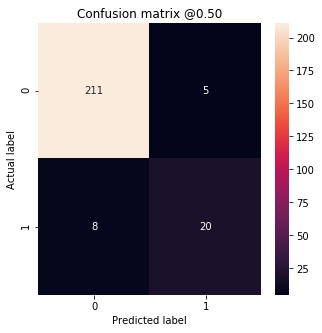

In [53]:
# evaluate predictions
test_predictions = loaded_model.predict(test_np)
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

plot_cm(test_labels, np.array(test_predictions))

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

Note that you can visualize the output as well using the SageMaker Experiments console. For the XGBoost experiment, this looked like. Note that your values may differ slightly.


![alt text](img/sm_experiments.png "SM Experiments")